## Brownlee LSTM blog adapted for btc

https://machinelearningmastery.com/use-features-lstm-networks-time-series-forecasting/

In [3]:
import pandas as pd
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from math import sqrt
import matplotlib.pyplot as plt
import numpy
from numpy import concatenate
import seaborn as sns
import matplotlib.pyplot as plt

Using TensorFlow backend.
/Users/tjd/anaconda/lib/python3.6/importlib/_bootstrap.py:205: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


In [19]:
# plot size
plt.rcParams["figure.figsize"] = (15,10)

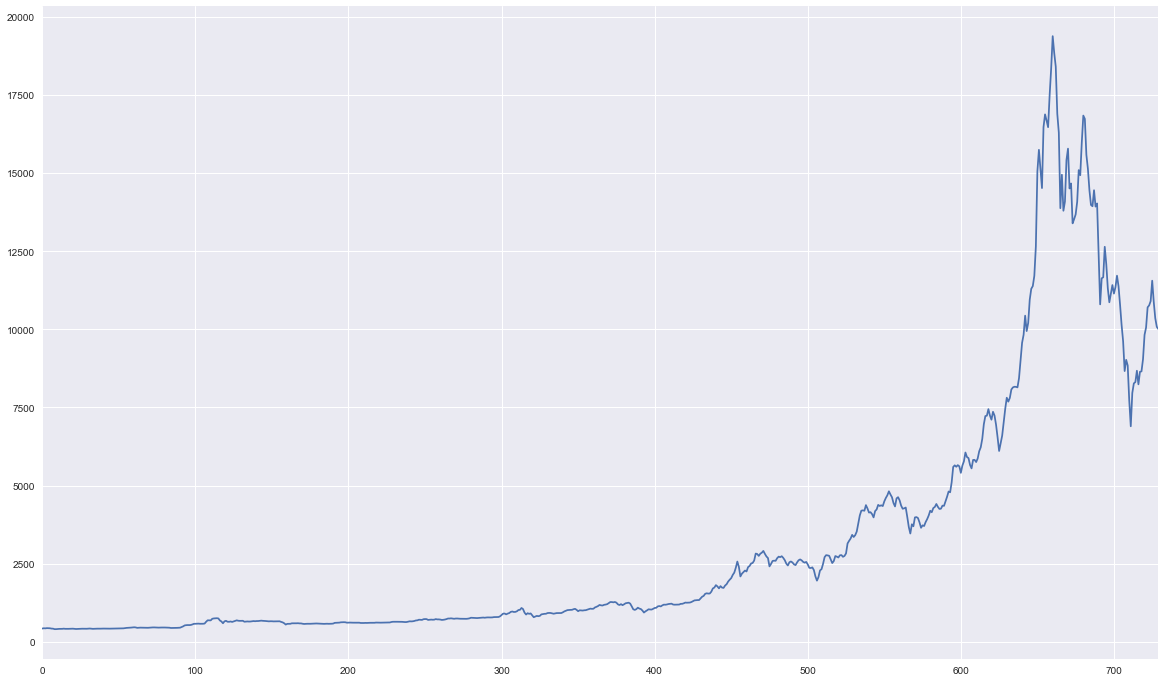

In [141]:
# get the data
fname="btc_td_diff.csv"
df = pd.read_csv(fname)
df['price'].plot()
plt.show()

### Drop columns that we don't need for collinearity or sparse info
We can drop date because we know the time period is daily. We can drop volatility because it's highly correlated with volume. We can drop goog-idx and diff_B for the time being. Might add them back later.

In [142]:
# prep the data 
df.drop(['diff_B', 'volatil', 'goog_idx', 'date'], axis=1, inplace=True)  
df.head(3)

,trans,bidask,price,volume,transpm,epu_idx,exp_sem
0,-12655,-0.035583,423.847443,6.176645e+06,-25.374167,41.87,0.106433
1,-21458,0.037374,431.913038,1.460536e+08,-42.287292,126.51,0.056521
2,51259,0.014298,428.947530,-4.094228e+07,31.346111,97.94,0.047878


In [143]:
# we must drop any NaN rows for LSTM to run
df.dropna(inplace=True)

### Brownlee functions
These are some of the functions Brownlee wrote to transform and un-transform the data. We'll be using adapted versions for our model. We won't use all of them since we already made our data stationary (differenced it) and created a target to predict. 

In [ ]:
# date-time parsing function for loading the dataset; NOT USED
def parser(x):
	return datetime.strptime(x, '%Y-%b')

# frame a sequence as a supervised learning problem; NOT USED
def timeseries_to_supervised(data, lag=1):
	df = pd.DataFrame(data)
	columns = [df.shift(i) for i in range(1, lag+1)]
	columns.append(df)
	df = pd.concat(columns, axis=1)
	return df

# create a differenced series
def difference(dataset, interval=1):
	diff = list()
	for i in range(interval, len(dataset)):
		value = dataset[i] - dataset[i - interval]
		diff.append(value)
	return pd.Series(diff)

# invert differenced value
def inverse_difference(history, yhat, interval=1):
	return yhat + history[-interval]

# scale train and test data to [-1, 1]
def scale(train, test):
	# fit scaler
	scaler = MinMaxScaler(feature_range=(-1, 1))
	scaler = scaler.fit(train)
	# transform train
	train = train.reshape(train.shape[0], train.shape[1])
	train_scaled = scaler.transform(train)
	# transform test
	test = test.reshape(test.shape[0], test.shape[1])
	test_scaled = scaler.transform(test)
	return scaler, train_scaled, test_scaled

# inverse scaling for a forecasted value
def invert_scale(scaler, X, yhat):
	new_row = [x for x in X] + [yhat]
	array = numpy.array(new_row)
	array = array.reshape(1, len(array))
	inverted = scaler.inverse_transform(array)
	return inverted[0, -1]

# fit an LSTM network to training data
def fit_lstm(train, batch_size, nb_epoch, neurons):
	X, y = train[:, 0:-1], train[:, -1]
	X = X.reshape(X.shape[0], 1, X.shape[1])
	model = Sequential()
	model.add(LSTM(neurons, batch_input_shape=(batch_size, X.shape[1], X.shape[2]), stateful=True))
	model.add(LSTM(neurons/2)
    model.add(Dense(1))
	model.compile(loss='mean_squared_error', optimizer='adam')
	for i in range(nb_epoch):
		model.fit(X, y, epochs=1, batch_size=batch_size, verbose=2, shuffle=False)
		model.reset_states()
	return model

# make a one-step forecast
def forecast_lstm(model, batch_size, X):
	X = X.reshape(1, 1, len(X))
	yhat = model.predict(X, batch_size=batch_size)
	return yhat[0,0]

# run a repeated experiment; NOT USED, WE TAKE PART OF IT TO COMPUTE RMSE
def experiment(repeats, series, features):
	# transform data to be stationary
	raw_values = series.values
	diff_values = difference(raw_values, 1)
	# transform data to be supervised learning
	supervised = timeseries_to_supervised(diff_values, features)
	supervised_values = supervised.values[features:,:]
	# split data into train and test-sets
	train, test = supervised_values[0:-12, :], supervised_values[-12:, :]
	# transform the scale of the data
	scaler, train_scaled, test_scaled = scale(train, test)
	# run experiment
	error_scores = list()
	for r in range(repeats):
		# fit the base model
		lstm_model = fit_lstm(train_scaled, 1, 500, 1)
		# forecast test dataset
		predictions = list()
		for i in range(len(test_scaled)):
			# predict
			X, y = test_scaled[i, 0:-1], test_scaled[i, -1]
			yhat = forecast_lstm(lstm_model, 1, X)
			# invert scaling
			yhat = invert_scale(scaler, X, yhat)
			# invert differencing
			yhat = inverse_difference(raw_values, yhat, len(test_scaled)+1-i)
			# store forecast
			predictions.append(yhat)
		# report performance
		rmse = sqrt(mean_squared_error(raw_values[-12:], predictions))
		print('%d) Test RMSE: %.3f' % (r+1, rmse))
		error_scores.append(rmse)
	return error_scores

# execute the experiment; NOT USED
def run():
	# load dataset
	series = read_csv('.csv', header=0, parse_dates=[0], index_col=0, squeeze=True, date_parser=parser)
	# experiment
	repeats = 10
	results = DataFrame()
	# run experiment
	features = 1
	results['results'] = experiment(repeats, series, features)
	# summarize results
	print(results.describe())
	# save results
	results.to_csv('experiment_features_1.csv', index=False)



### Create the 1-day lagged price as target variable 'y'
We are trying to predict the next day's price based on the data we know today. The next series of steps adds our features together with y = t+1. So now we have the next day's true price (y) and today's knowledge (X) in each observation.

#### Step 1: Difference the price

In [159]:
# first we have to difference the price
# we're using Brownlee's function to do this so we can undifference it later
raw_values = df['price'].values
diff_values = difference(raw_values, 1)
diff_values.head()

In [167]:
len(diff_values)

717

#### Step 2: Create our lagged ahead target price 'y'

In [175]:
# transform data to be supervised learning
supervised = timeseries_to_supervised(diff_values, 1)

In [177]:
len(supervised)

717

In [180]:
supervised[0:5]

,0,0
0,NaN,8.065595
1,8.065595,-2.965509
2,-2.965509,7.212824
3,7.212824,-2.126012
4,-2.126012,-2.332787


#### Step 3: Combine with our other features

In [181]:
df.head(5)

,trans,bidask,price,volume,transpm,epu_idx,exp_sem
0,-12655,-0.035583,423.847443,6.176645e+06,-25.374167,41.87,0.106433
1,-21458,0.037374,431.913038,1.460536e+08,-42.287292,126.51,0.056521
2,51259,0.014298,428.947530,-4.094228e+07,31.346111,97.94,0.047878
3,31884,0.065002,436.160354,2.760379e+08,118.520208,65.74,0.139419
4,11774,-0.024977,434.034342,-3.762465e+08,-24.499028,49.35,0.099477


In [188]:
# concatenate the data, rename columns
df2 = pd.DataFrame(pd.concat([df, supervised], axis=1))
df2.columns.values[7] = 'd_price' 
df2.columns.values[7] = 'y'

In [196]:
 df2.dropna(inplace=True); df2.info()

In [212]:
# delete old price column
df2.drop(['price'], axis=1, inplace=True)

In [216]:
# inspect; we should have seven features (X) and our target(y)
df2.head()

,trans,bidask,volume,transpm,epu_idx,exp_sem,d_price,y
1,-21458.0,0.037374,1.460536e+08,-42.287292,126.51,0.056521,8.065595,-2.965509
2,51259.0,0.014298,-4.094228e+07,31.346111,97.94,0.047878,-2.965509,7.212824
3,31884.0,0.065002,2.760379e+08,118.520208,65.74,0.139419,7.212824,-2.126012
4,11774.0,-0.024977,-3.762465e+08,-24.499028,49.35,0.099477,-2.126012,-2.332787
5,-6888.0,-0.019619,-3.596977e+06,-11.184444,41.64,0.022288,-2.332787,-10.136824


In [217]:
len(df2)

715

### Convert to an array

In [214]:
supervised_values = df2.values
supervised_values[0:2]

array([[ -2.14580000e+04,   3.73739800e-02,   1.46053568e+08,
         -4.22872916e+01,   1.26510000e+02,   5.65214290e-02,
          8.06559490e+00,  -2.96550870e+00],
       [  5.12590000e+04,   1.42977500e-02,  -4.09422832e+07,
          3.13461111e+01,   9.79400000e+01,   4.78777780e-02,
         -2.96550870e+00,   7.21282440e+00]])

In [231]:
len(supervised_values)

715

### Make training, test sets; scale the data
We have 715 observations. We'll train on 500 and test on 215. We use Brownlee's scale() function to rescale everything between (-1,1). This is required for LSTM.

In [232]:
# split data into train and test-sets
train, test = supervised_values[0:-215, :], supervised_values[-215:, :]

# transform the scale of the data
scaler, train_scaled, test_scaled = scale(train, test)

# make X, y training set; this is done in the next function
# X, y = train_scaled[:, 0:-1], train_scaled[:, -1]

### Make and fit the model
This uses Brownlee's fit_lstm() function to build a 1-layer model. As parameters, it takes our scaled training data X, a batch size (1), number of epochs (20), and number of neurons (1). Before building the model, it reshapes the data as LSTM expects to get it. I chose these parameters for convenience. They can be tuned.

In [255]:
# def fit_lstm(train, batch_size, nb_epoch, neurons)
# fit model to scaled data, 1 batch, 50 epochs, 1 neuron
lstm_model = fit_lstm(train_scaled, 1, 50, 20)

Epoch 1/1
 - 3s - loss: 0.0225
Epoch 1/1
 - 2s - loss: 0.0202
Epoch 1/1
 - 2s - loss: 0.0200
Epoch 1/1
 - 2s - loss: 0.0199
Epoch 1/1
 - 2s - loss: 0.0198
Epoch 1/1
 - 2s - loss: 0.0197
Epoch 1/1
 - 2s - loss: 0.0196
Epoch 1/1
 - 2s - loss: 0.0195
Epoch 1/1
 - 2s - loss: 0.0194
Epoch 1/1
 - 2s - loss: 0.0193
Epoch 1/1
 - 2s - loss: 0.0193
Epoch 1/1
 - 2s - loss: 0.0192
Epoch 1/1
 - 2s - loss: 0.0191
Epoch 1/1
 - 2s - loss: 0.0191
Epoch 1/1
 - 2s - loss: 0.0190
Epoch 1/1
 - 2s - loss: 0.0190
Epoch 1/1
 - 2s - loss: 0.0189
Epoch 1/1
 - 2s - loss: 0.0188
Epoch 1/1
 - 2s - loss: 0.0188
Epoch 1/1
 - 2s - loss: 0.0187
Epoch 1/1
 - 2s - loss: 0.0187
Epoch 1/1
 - 2s - loss: 0.0186
Epoch 1/1
 - 2s - loss: 0.0186
Epoch 1/1
 - 2s - loss: 0.0185
Epoch 1/1
 - 2s - loss: 0.0184
Epoch 1/1
 - 2s - loss: 0.0183
Epoch 1/1
 - 2s - loss: 0.0182
Epoch 1/1
 - 2s - loss: 0.0181
Epoch 1/1
 - 2s - loss: 0.0180
Epoch 1/1
 - 2s - loss: 0.0179
Epoch 1/1
 - 2s - loss: 0.0178
Epoch 1/1
 - 2s - loss: 0.0177
Epoch 1/

### Make predictions and compute error (RMSE)
This code is an adaptation of Brownlee's. It takes the test data, makes predictions using Brownlee's forecast_lstm() function, inverts the scaling and differencing, and returns the error score in dollars.

In [256]:
predictions = list()
for i in range(len(test_scaled)):
	# predict
	X, y = test_scaled[i, 0:-1], test_scaled[i, -1]
	yhat = forecast_lstm(lstm_model, 1, X)
	# invert scaling
	yhat = invert_scale(scaler, X, yhat)
	# invert differencing
	yhat = inverse_difference(raw_values, yhat, len(test_scaled)+1-i)
	# store forecast
	predictions.append(yhat)
# report performance
rmse = sqrt(mean_squared_error(raw_values[-215:], predictions))
print('%d) Test RMSE: %.3f' % (1 ,rmse))

1) Test RMSE: 525.370


In [249]:
lstm_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_6 (LSTM)                (1, 1)                    36        
_________________________________________________________________
dense_6 (Dense)              (1, 1)                    2         
Total params: 38
Trainable params: 38
Non-trainable params: 0
_________________________________________________________________


In [259]:
raw_values[-215:]

array([  2294.045639,   2092.468244,   1956.442632,   2069.55207 ,
         2282.229995,   2324.181149,   2495.685191,   2709.425251,
         2772.18081 ,   2764.690577,   2751.010088,   2633.923639,
         2519.909842,   2583.746771,   2743.616904,   2724.361001,
         2697.246589,   2767.910668,   2775.183747,   2719.683921,
         2747.616117,   2828.760316,   3147.13161 ,   3230.633058,
         3305.211277,   3421.95642 ,   3354.059282,   3413.142136,
         3528.925854,   3782.750412,   4044.53995 ,   4196.783664,
         4206.299578,   4194.705319,   4374.806291,   4267.39414 ,
         4136.1659  ,   4148.029651,   4087.139319,   3981.514068,
         4183.225291,   4236.453566,   4382.384089,   4347.394396,
         4369.042611,   4343.959435,   4494.437119,   4603.538066,
         4689.906061,   4816.73266 ,   4716.671551,   4627.983777,
         4441.606165,   4331.903652,   4589.850046,   4628.605283,
         4528.176639,   4358.067373,   4258.579102,   4271.211

In [262]:
df.tail(215)

,trans,bidask,price,volume,transpm,epu_idx,exp_sem
504,-17992,-0.008556,2294.045639,4.910100e+07,6.188349,90.61,0.043120
505,-6052,0.081324,2092.468244,5.298055e+07,6.975000,49.96,0.148599
506,-18686,0.066794,1956.442632,3.422464e+07,4.696682,147.91,0.045302
507,27150,-0.037794,2069.552070,-1.832864e+06,-2.489660,92.60,0.082743
508,30260,-0.009860,2282.229995,6.792074e+07,3.249614,88.82,0.179711
509,-6807,-0.040912,2324.181149,-8.682578e+07,-3.730556,51.42,0.184377
510,-23569,-0.054166,2495.685191,3.735080e+08,15.653241,100.40,0.131258
511,38244,-0.010105,2709.425251,-2.343145e+08,-13.109182,73.36,0.135331
512,-45085,-0.024328,2772.180810,-1.567213e+08,-10.210957,64.94,0.084102
513,-42327,0.017585,2764.690577,-1.642497e+07,-1.919059,134.15,0.067051


In [265]:
predictions

[2377.2509848238301,
 2273.6507395997437,
 2074.1564287468527,
 2023.5856764245536,
 2084.3678632171063,
 2328.9329762381744,
 2355.6507476798952,
 2548.8269126214254,
 2700.3537769759819,
 2844.1369764708261,
 2807.4480631558135,
 2765.6477441748057,
 2621.2743226016064,
 2384.6718275332887,
 2558.3735832705092,
 2768.5903424282801,
 2727.9735156974484,
 2692.6709068999653,
 2785.7248294722867,
 2790.6889271647497,
 2728.0634610512188,
 2764.44950688157,
 2846.0233607994624,
 3217.6671317762334,
 3223.8051530510797,
 3356.4218248392613,
 3469.8940036582098,
 3328.4717618787131,
 3412.6127010882242,
 3569.1418871960927,
 3828.0680369300571,
 4075.4654183946964,
 4230.5090183279663,
 4228.2689727232882,
 3988.795050951072,
 4312.9704214747917,
 4073.4231331385622,
 3891.102299798672,
 4089.7363008079901,
 4210.574017318967,
 4100.1164039829637,
 4298.7620761352155,
 4253.0828218730694,
 4413.5244640643878,
 4357.7340653208712,
 4378.0605460823772,
 4336.8560984518581,
 4509.686250434598

In [271]:
pd.DataFrame(raw_values).to_csv('raw_values.csv')